In [1]:
using DelimitedFiles
using PyPlot
using Statistics
using JLD2
close("all")

include("fran_torch.jl")

cd("C:\\Users\\Gabriel Francisco\\Desktop\\Curso CNN")

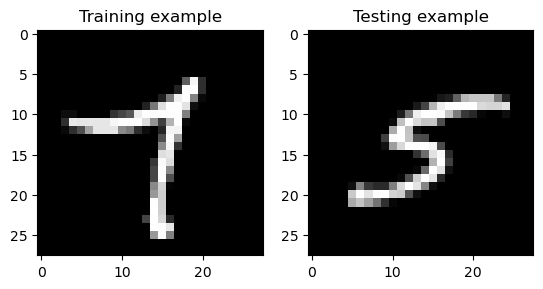

In [2]:
#LOADING DATASET
data = readdlm("mnist_10000.txt")[:,2:end]
labels = readdlm("mnist_10000.txt")[:,1]
n_classes = length(unique(labels))
data_test = readdlm("mnist_test.txt")[:,2:end]
labels_test = readdlm("mnist_test.txt")[:,1]

m_in = 28
n_in = 28

X_im = zeros(m_in,n_in, size(data,1)) #training inputs
one_hot_outputs = zeros(n_classes, size(data,1))
X_im_test = zeros(m_in,n_in,size(data_test,1)) #testing inputs
one_hot_outputs_test = zeros(n_classes, size(data_test,1))

for i in 1:size(data,1)
    global X_im[:,:, i] = copy(reshape(data[i,:], m_in, n_in)')
    global one_hot_outputs[Int(labels[i])+1,i] = 1 
end 

for i in 1:size(data_test,1)
    global X_im_test[:,:,i] = copy(reshape(data_test[i,:], m_in, n_in)')
    global one_hot_outputs_test[Int(labels_test[i])+1,i] = 1
end 

X_im = X_im/255 #feature standartization
X_im_test = X_im_test/255

ex_1 = sortperm(rand(size(data,1)))[1]
ex_2 = sortperm(rand(size(data_test,1)))[1]

figure()
subplot(121)
imshow(X_im[:,:,ex_1], cmap = "gray")
title("Training example")
subplot(122)
imshow(X_im[:,:,ex_2], cmap = "gray")
title("Testing example")
display(gcf())

In [11]:
#splitting the training set into minibatches
n_batches = 156
batch_size = Int(floor(size(X_im)[end]/n_batches))
shuffled_idx = sortperm(rand(size(X_im)[end]))
batches = [] 
for n in 1:n_batches-1
    push!(batches, shuffled_idx[(n-1)*batch_size+1:n*batch_size])
end
push!(batches, shuffled_idx[(n_batches-1)*batch_size+1:end]);


In [12]:
#####DEFINING THE MODEL######
model = network([conv2d(k=5, channels=6, stride=1, activation="tanh"),
                 maxpooling(k=2, stride=2),
                 conv2d(k=3, channels=16, stride=1, activation="tanh"),
                 maxpooling(k=2, stride=2),
                 flatten(),
                 dense(n_out=120, activation="tanh"),
                 dense(n_out=84, activation="tanh"),
                 dense(n_out=10, activation="tanh"),
                 softmax() 
], 0, 0)

model = init_weights(model, m_in, n_in);

In [13]:
lr = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
epochs = 20

train_accs = []
val_accs = []

train_losses = []
val_losses = [];


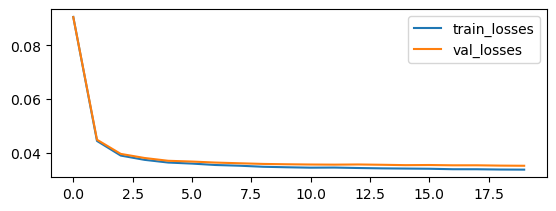

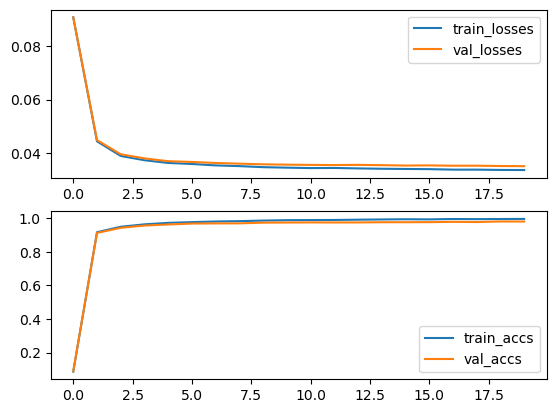

Final Accuracy (Validation Set): 0.9813


In [14]:
for epoch in 1:epochs
    #global cont +=1
    #println(epoch)

    #avaliando desempenho na base de treinamento
    #inputs = X_im[:,:,training_idx]
    #ground_truth = one_hot_outputs[:, training_idx]
    loss, acc = evaluate_nn(X_im, one_hot_outputs)
    push!(train_losses, loss)
    push!(train_accs, acc)


    #avaliando desempenho na base de validacao
    #inputs = X_im[:, :, test_idx]
    #ground_truth = one_hot_outputs[:, test_idx]
    loss, acc = evaluate_nn(X_im_test, one_hot_outputs_test)
    push!(val_losses, loss)
    push!(val_accs, acc)
    
    #treinamento
    train_nn(batches, X_im, one_hot_outputs, "adam")
end

figure()
subplot(211)
plot(train_losses)
hold
plot(val_losses)
legend(["train_losses", "val_losses"])
display(gcf())

subplot(212)
plot(train_accs)
hold
plot(val_accs)
legend(["train_accs", "val_accs"]) 
display(gcf())


println("Final Accuracy (Validation Set): ", val_accs[end])